In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pymc as pm
from pymc.ode import DifferentialEquation

from itertools import product
import os.path as osp
from scipy.optimize import leastsq
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import math
import time
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
from IPython.display import display as print

from scipy.integrate import odeint

from datetime import datetime
from core_lib import MyDataset,get_format_time,get_dcdts_for_scipy_odeint, plot_dataset,r2_loss,get_predict_ks

In [3]:

# simulator function
def competition_model(rng, t_eval, y0,  ks, k_kinetics, size=None):
    # print(y0)
    y = odeint(get_dcdts_for_scipy_odeint(), y0=y0, t=t_eval, args=(ks, k_kinetics))
    return y


In [5]:

def get_model(dataset, t_eval, k_kinetics, k_sigma_priors=0.01, kf_type=0):
    df = dataset.get_df()
    times = df['time'].values
    cct_names, error_names = dataset.get_var_col_names()
    ccts = dataset.get_cct()
    
    mcmc_model = pm.Model()
    params_n = 11

    parames =[]
    c0 = []
    # c0 = dataset.get_cct()[0]
    with mcmc_model:
        for ki in range(1, params_n + 1):
            if kf_type == 0:
                p_dense = pm.HalfNormal(f"k{ki}", sigma=k_sigma_priors)
            else:
                p_dense = pm.Normal(f"k{ki}",mu=0, sigma=k_sigma_priors)
            parames.append(p_dense)
        
        for c_name in cct_names:
            _maxx = df[c_name].values.max()
            c0.append(pm.HalfNormal(f"{c_name}_s", sigma=_maxx))
    
    with mcmc_model:
        sim = pm.Simulator("sim", competition_model, params=(t_eval, c0, parames, k_kinetics), epsilon=1, observed=ccts)
        # sim = pm.Simulator("sim", competition_model, params=(t_eval,), epsilon=1, observed=ccts)
        
    return mcmc_model


In [6]:
k_kinetics = np.repeat(1, 11).astype(np.uint8)
# ks = np.random.random(11)/100 # 先验k
ks = np.array([0.00071942, 0.00269696, 0.00498945, 0.00444931, 0.00571299, 0.00801272, 0.00131931, 0.00319959, 0.00415571, 0.00228432, 0.00177611])
#  =======================================================

t_eval = np.arange(0, 150, 5)
dataset = MyDataset("dataset/data.csv")
df = dataset.get_df()
cct_names, error_names = dataset.get_var_col_names()

c0 = df[cct_names].iloc[0].values
dataset.set_as_sim_dataset(get_dcdts_for_scipy_odeint(), t_eval, c0, args=(ks, k_kinetics))
df = dataset.get_df()

mcmc_model = get_model(dataset, t_eval, k_kinetics, k_sigma_priors=0.01, kf_type=0)


array([0.00071942, 0.00269696, 0.00498945, 0.00444931, 0.00571299,
       0.00801272, 0.00131931, 0.00319959, 0.00415571, 0.00228432,
       0.00177611])

array([1.16666667e+00, 2.39880952e+00, 3.11000000e-02, 6.22850000e+01,
       7.11000000e-05, 7.94863498e+00, 6.85792330e-02, 7.23100000e-02,
       9.85666700e-03, 8.32000000e-03])

/var/folders/90/l1bfwzjx4ms6v5_k7236h2n40000gn/T/ipykernel_15192/1967272327.py:37: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


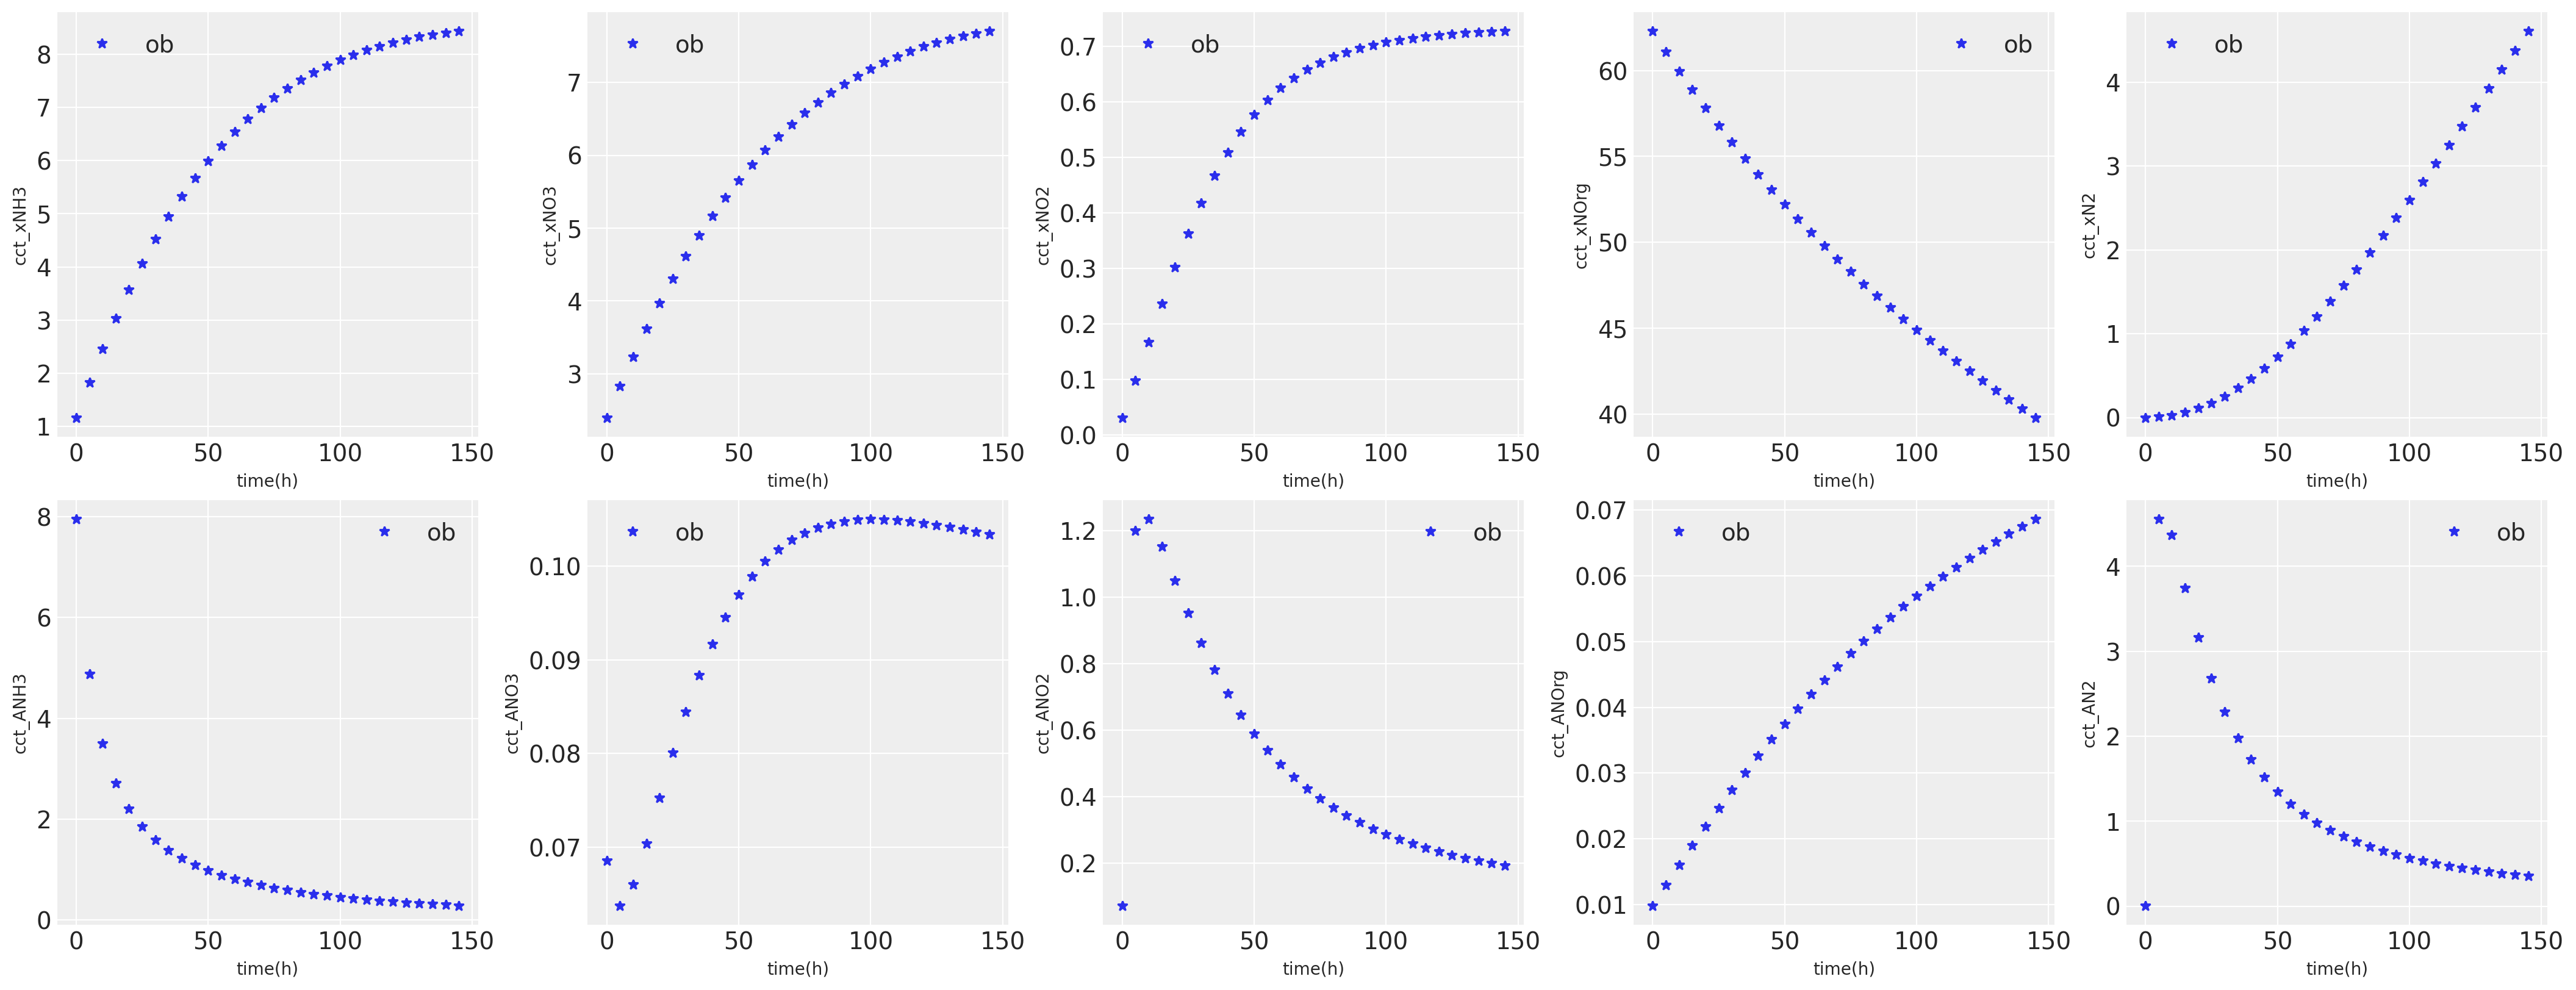

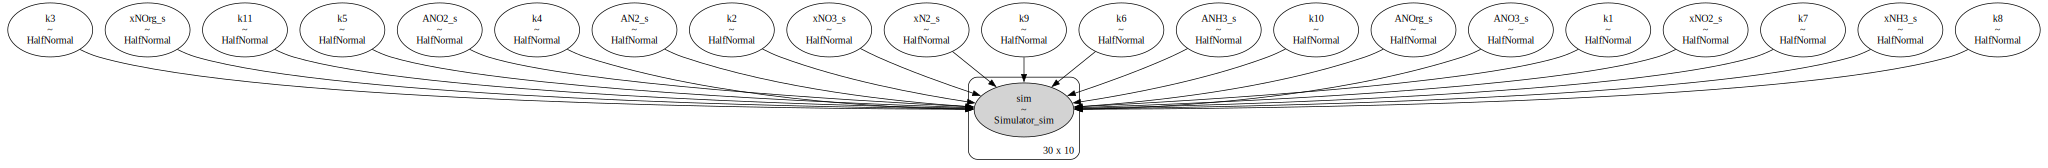

In [7]:
print(ks, c0)
plot_dataset(dataset)
pm.model_to_graphviz(mcmc_model)

In [ ]:
with mcmc_model:
    idata_lv = pm.sample_smc(cores=4, progressbar=False)
# 本次实验要证明是否有bug，是否可重现当时的结果

In [ ]:
az.plot_trace(idata_lv, kind="rank_vlines")

In [ ]:
az.summary(idata_lv)

In [ ]:

ks_predict = get_predict_ks(idata_lv)
k_kinetics = np.repeat(1, 11).astype(np.uint8)
t_eval = np.arange(0, 150, 5)

dataset_new = MyDataset("dataset/data.csv")
cct_names, error_names = dataset_new.get_var_col_names()
dataset_new.set_as_sim_dataset(get_dcdts_for_scipy_odeint(), t_eval, dataset_new.get_cct()[0], args=(ks_predict, k_kinetics))

print("r2_loss", r2_loss(dataset_new.get_cct(), dataset.get_cct()))
plot_dataset(dataset, dataset_new)


In [ ]:
az.plot_posterior(idata_lv);

In [ ]:
# plot results
_, ax = plt.subplots(figsize=(14, 6))
posterior = idata_lv.posterior.stack(samples=("draw", "chain"))
ax.plot(observed[:, 0], "o", label="prey", c="C0", mec="k")
ax.plot(observed[:, 1], "o", label="predator", c="C1", mec="k")

y_posterior = ( posterior["y0_1"].mean(), posterior["y0_2"].mean())
ax.plot(competition_model(None, y_posterior, posterior["a"].mean(), posterior["b"].mean()), linewidth=3)
for i in np.random.randint(0, size, 10):
    sim = competition_model(None, (posterior["y0_1"][i], posterior["y0_2"][i]), posterior["a"][i], posterior["b"][i])
    ax.plot(sim[:, 0], alpha=0.1, c="C0")
    ax.plot(sim[:, 1], alpha=0.1, c="C1")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.legend();